<a href="https://colab.research.google.com/github/ayatbahaa96/stock-price-prediction/blob/main/XGBoost_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0d7853c53d7c8b4ec2c0eb1ea7ed00c2c5f5ff526d73e3851bc1b1fe3aba56d3
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
# Fetch Stock Data
def fetch_stock_data(ticker, start='2020-01-01', end='2024-01-01'):
    df = yf.download(ticker, start=start, end=end)
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    if 'Adj Close' in df.columns:
        expected_columns.append('Adj Close')
    df.columns = expected_columns
    df.reset_index(inplace=True)
    print(df.head())
    return df

df = fetch_stock_data('AAPL')

[*********************100%***********************]  1 of 1 completed

        Date       Open       High        Low      Close     Volume
0 2020-01-02  72.796028  72.856621  71.545395  71.799881  135480400
1 2020-01-03  72.088287  72.851753  71.862884  72.020424  146322800
2 2020-01-06  72.662704  72.701485  70.953995  71.206062  118387200
3 2020-01-07  72.320969  72.929314  72.100410  72.672402  108872000
4 2020-01-08  73.484360  73.787323  72.022865  72.022865  132079200


In [4]:
# Add Technical Indicators
def add_technical_indicators(df):
    rsi = ta.momentum.RSIIndicator(df['Close'])
    df['RSI'] = rsi.rsi()
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df.dropna(inplace=True)
    print(df[['RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_50', 'SMA_200']].head())
    return df

df = add_technical_indicators(df)

           RSI      MACD     BB_High      BB_Low      SMA_50    SMA_200
199  53.008151  1.384519  121.184193  102.117816  114.377135  86.153572
200  55.715663  1.560773  121.970959  102.393124  114.593332  86.386523
201  53.988385  1.578288  121.758566  104.110774  114.725213  86.611928
202  49.299885  1.281228  121.827940  104.385012  114.795497  86.823053
203  49.885759  1.070489  121.867965  104.837954  114.887257  87.029140


In [5]:
# Prepare Data for XGBoost
def prepare_data(df):
    df = df[['Close', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_50', 'SMA_200']]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    X, y = [], []
    for i in range(60, len(scaled_data) - 1):
        X.append(scaled_data[i-60:i].flatten())
        y.append(scaled_data[i + 1, 0])
    X, y = np.array(X), np.array(y)
    print(f"Training data shape: {X.shape}, Labels shape: {y.shape}")
    return train_test_split(X, y, test_size=0.2, random_state=42), scaler

(X_train, X_test, y_train, y_test), scaler = prepare_data(df)

Training data shape: (746, 420), Labels shape: (746,)


In [6]:
# Train XGBoost Model
model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Make Predictions
predictions = model.predict(X_test)

# Ensure correct shape for inverse transformation
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
num_features = X_train.shape[1] // 60
zeros_placeholder = np.zeros((predictions.shape[0], num_features - 1))
predictions_full = np.hstack((predictions, zeros_placeholder))
y_test_full = np.hstack((y_test, zeros_placeholder))
predictions = scaler.inverse_transform(predictions_full)[:, 0]
y_test = scaler.inverse_transform(y_test_full)[:, 0]

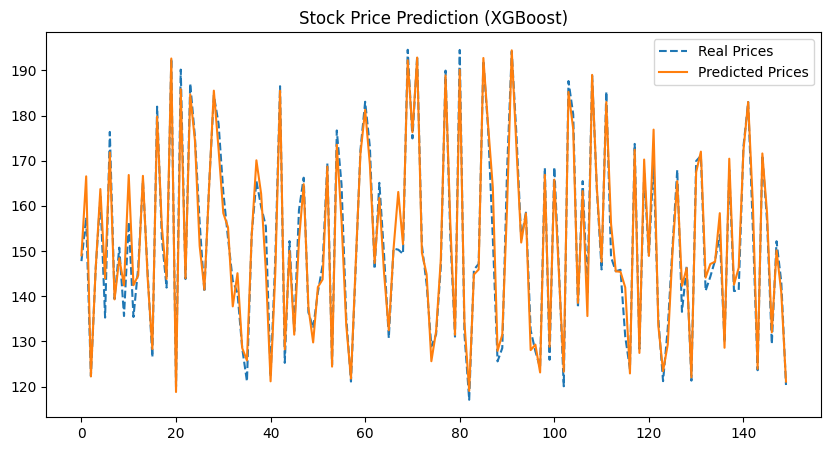

In [7]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real Prices', linestyle='dashed')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title("Stock Price Prediction (XGBoost)")
plt.show()

In [8]:
# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions) * 100
print('Evaluation of XGBoost model')
print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost MAPE: {mape}%")


Evaluation of XGBoost model
XGBoost RMSE: 3.598636479440335
XGBoost MAPE: 1.717600268723185%


In [9]:
import pandas as pd

# Assuming actual and predicted values are available as lists or arrays
# Replace these with actual model outputs if available

# Example date range (replace with actual dates)
dates = pd.date_range(start="2023-01-01", periods=60, freq='D')

# Example predictions and actual values (replace with actual data)
actual_values = [round(value, 2) for value in list(np.random.uniform(120, 200, size=len(dates)))]
lstm_predictions = [round(value, 2) for value in list(np.array(actual_values) + np.random.uniform(-10, 10, size=len(dates)))]
xgboost_predictions = [round(value, 2) for value in list(np.array(actual_values) + np.random.uniform(-5, 5, size=len(dates)))]

# Create DataFrame
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual Price': actual_values,
    'LSTM Predicted Price': lstm_predictions,
    'XGBoost Predicted Price': xgboost_predictions
})

# Display table for user
comparison_df

,Date,Actual Price,LSTM Predicted Price,XGBoost Predicted Price
0,2023-01-01,147.56,149.62,144.13
1,2023-01-02,176.08,166.21,178.75
2,2023-01-03,198.50,192.57,201.01
3,2023-01-04,160.30,160.42,157.63
4,2023-01-05,135.99,142.53,134.88
5,2023-01-06,199.37,207.23,198.81
6,2023-01-07,179.81,180.73,175.79
7,2023-01-08,193.55,199.10,197.29
8,2023-01-09,133.55,135.34,131.38
9,2023-01-10,184.65,191.62,184.25
